# MidTerm Project
Safe drinking water is a necessity and right for all humans. However, many people around the world still lack access to safe drinking water. In this project, we will analyze a dataset related to water quality and build machine learning models to predict water potability. This will benefit organizations and governments in identifying unsafe water sources and taking necessary actions to ensure access to safe drinking water.

Data used from Kaggle [here](https://www.kaggle.com/datasets/adityakadiwal/water-potability/data).

The dataset contains water quality metrics for 3276 different water bodies. Following are the features in the dataset:
1. ph
2. Hardness
3. Solids
4. Chloramines
5. Sulfate
6. Conductivity
7. Organic_carbon
8. Trihalomethanes
9. Turbidity
10. Potability (1 if safe for human consumption, 0 otherwise)

## Objective
- Objective of the project is to build classification models to predict whether the water is potable (safe for human consumption) or not based on the water quality metrics.
- Three models will be built and compared:
  1. Decision Tree Classifier
  2. Random Forest Classifier
  3. XGBoost Classifier

## Import the necessary libraries

In [110]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Load the data CSV

In [2]:
# Load the dataset
data_file = "water_potability.csv"
df = pd.read_csv(data_file)

# Display the first few rows of the dataframe
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## EDA : Exploratory Data Analysis

### Shape of the data

In [3]:
# Get the shape of the dataframe
df.shape

(3276, 10)

- The application dataset has 3276 rows and 10 columns

### Data Types

In [4]:
# get data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- All columns are numeric
- `Potability` is the target variable and is a numeric column with values 0 and 1 (integer)
- Other 9 columns are features and are float type

### Statistical Summary

In [5]:
# Basic statistics of the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


- Following columns have missing values
  - ph (491)
  - Sulfate (781)
  - Trihalomethanes (162)
- Class imbalance is moderate
  - 39% potable (value 1) samples
  - 61% non-potable samples (value 0).
- Outliers : `Ph`, `Trihalomethanes`, `Solids` have outliers with
  - `ph` minimum being 0 (implausible),
  - `Trihalomethanes` min very low at 0.7 and
  - `Solids` max extremely high at 61227
- Central tendency of mean and median (50%) are closer for most features indicating limited skewness, except for `Solids` which is slightly right-skewed (mean is greater than median).
- Data Spread shows High variability in Solids (~0.40); moderate in `Trihalomethanes`, `Organic_carbon`, `ph`, `Chloramines`; low in `Sulfate`, `Hardness`.

### Missing values

In [6]:
# Check for missing values to confirm the statistical summary observations
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

- From the output above, we can see that the dataset contains the same missing values for `ph`, `Sulfate`, and `Trihalomethanes` columns.

### Class imbalance check

In [7]:
# check for class imbalance
df['Potability'].value_counts(normalize=True)

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

- The target variable 'Potability' shows a moderate class imbalance with approximately 39% potable (1) and 61% non-potable (0) samples.

### Univariate analysis
- Following section will perform univariate analysis of the features in the dataset for all the numerical values except the target variable `Potability`.

#### Numerical variables and histogram

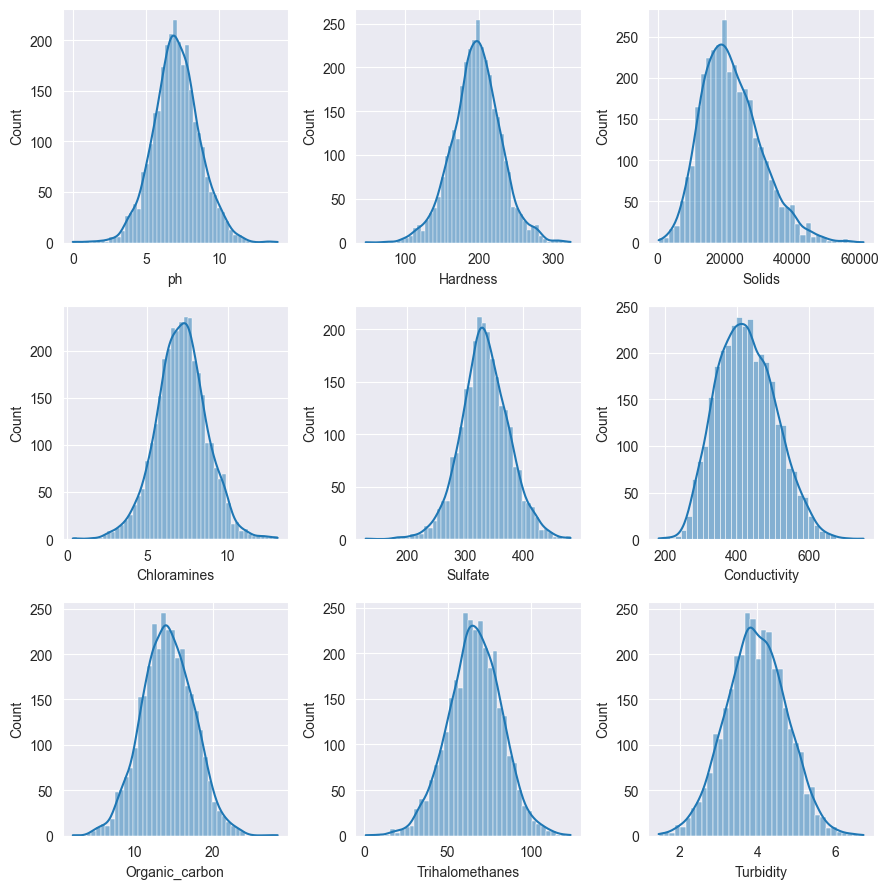

In [8]:
# declare the numerical columns in `num_features` variable
num_features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# define the plot figure size
plt.figure(figsize=(9, 9))

# plotting the histogram for each numerical feature
for i, feature in enumerate(num_features):
    plt.subplot(3, 3, i+1)    # assign a subplot in the main plot
    sns.histplot(data=df, x=feature, kde=True)    # plot the histogram on log scale

plt.tight_layout();   # to add spacing between plots
plt.show()

- Most features are unimodal and roughly normal;
- `Solids` is right-skewed with a long tail towards higher values
- Moderate right skew in `Conductivity`, `Trihalomethanes`, `Organic_carbon`, `Turbidity`
- This confirms that `Solids` needs outlier handling and `ph` needs data cleaning for the zero values before modeling.

#### Numerical (continuous) variables and Box plots

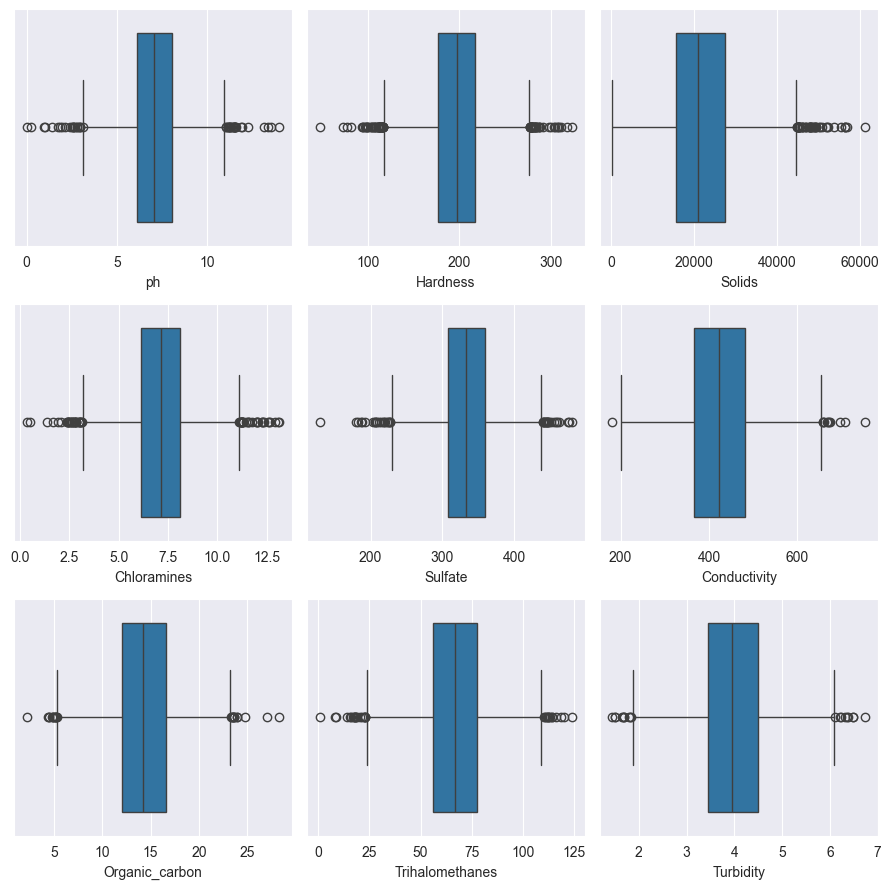

In [9]:
# define the plot figure size
plt.figure(figsize=(9, 9))

# plotting the boxplots for each numerical feature
for i, feature in enumerate(num_features):
    plt.subplot(3, 3, i+1)    # assign a subplot in the main plot
    sns.boxplot(data=df, x=feature)    # plot the boxplot

plt.tight_layout();   # to add spacing between plots
plt.show()

- The box plots for the numerical features confirm the presence of strong outliers in `Solids`
- `Trihalomethanes` and `ph` also have moderate outliers.

### BiVariate Analysis

#### Numerical variables correlation using Heatmap

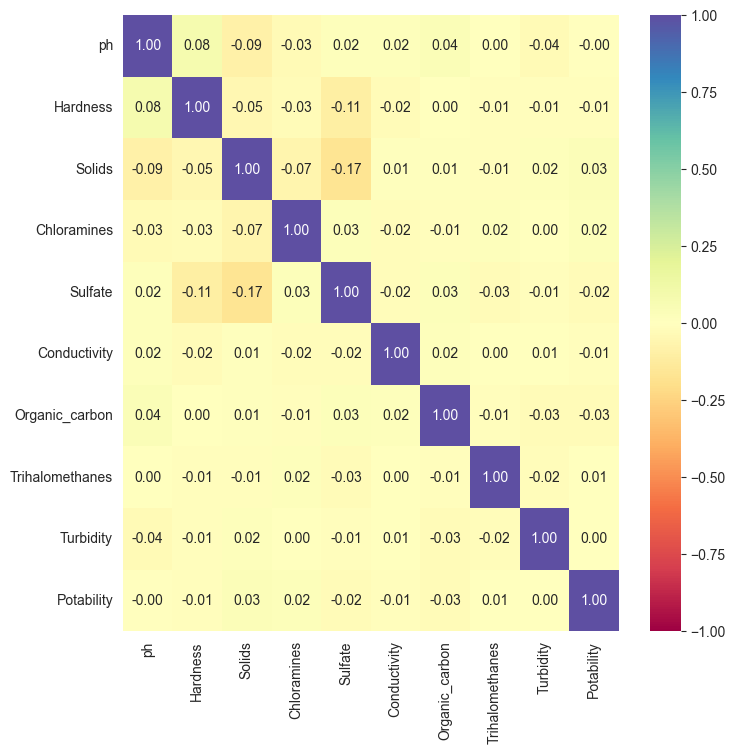

In [10]:
# defining the size of the plot
plt.figure(figsize=(8,8))

# plotting the heatmap for correlation
sns.heatmap(
    df.corr(),annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
);
plt.show()

- Overall low pairwise correlations can be observed i.e., no strong multicollinearity
- Very modest positive relations likely among e.g., Hardness–Conductivity–Solids; But truly small
- Potability shows only weak linear correlations with individual features
- All features are imporant and shall be retained

## Data Cleaning and Preparation
- Data will be split into train, validation and test sets by using `train_test_split` function from sklearn twice.
- `SimpleImputer` will be used to impute missing values with Median strategy.
  - `Median` strategy is preferred over `Mean` as it is more robust to outliers
  - `ph`, `Sulfate`, and `Trihalomethanes` columns are treated using Median strategy
- `ph==0` is fixed first as missing before splitting

In [12]:
# define X and y
X = df[num_features]
y = df['Potability']

In [13]:
# Train/validation/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

In [16]:
# Custom transformer: set ph==0 to NaN
class PhZeroToNaN(BaseEstimator, TransformerMixin):
    def __init__(self, ph_col="ph"):
        self.ph_col = ph_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        if self.ph_col in Xc.columns:
            Xc.loc[Xc[self.ph_col] == 0, self.ph_col] = np.nan
        return Xc

# Preprocessing: ph fix + median impute
preprocess = make_column_transformer(
    (Pipeline([
        ("ph_fix", PhZeroToNaN(ph_col="ph")),
        ("impute", SimpleImputer(strategy="median"))
    ]), num_features),
    remainder='drop'
)

In [21]:
# declare map to store auc scores of different models
model_auc_scores = {}

## Model 1 : Decision Tree

In [83]:
# create the Decision Tree model
model1 = DecisionTreeClassifier(
    max_depth=10,
    random_state=42)

# create the pipeline for model 1
model1_pipeline = make_pipeline(preprocess, model1)

# Train the model pipeline on the training data
model1_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('ph_fix',
                                                                   PhZeroToNaN()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ph', 'Hardness', 'Solids',
                                                   'Chloramines', 'Sulfate',
                                                   'Conductivity',
                                                   'Organic_carbon',
                                                   'Trihalomethanes',
                                                   'Turbidity'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [84]:
# Predict probabilities on the validation set
y_val_pred = model1_pipeline.predict_proba(X_val)[:, 1]

# Calculate AUC score for model 1
model1_auc = roc_auc_score(y_val, y_val_pred)

# store the auc score in the dictionary
model_auc_scores['Model 1 : Decision Tree'] = model1_auc

# print Model auc score
print(f"Model 1 : Decision Tree AUC: {model1_auc:.4f}")

Model 1 : Decision Tree AUC: 0.6206


## Model 2 : Random Forest Classifier

In [77]:
# create the Random Forest classifier model
model2 = RandomForestClassifier(n_estimators=400,
                                min_samples_split=3,
                                random_state=42,
                                n_jobs=-1)

# create the pipeline for model 2
model2_pipeline = make_pipeline(preprocess, model2)

# Train the model pipeline on the training data
model2_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('ph_fix',
                                                                   PhZeroToNaN()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ph', 'Hardness', 'Solids',
                                                   'Chloramines', 'Sulfate',
                                                   'Conductivity',
                                                   'Organic_carbon',
                                                   'Trihalomethanes',
                                                   'Turbidity'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=3, n_estimators=400,
                                        n_jobs=-1, random_state=42))])

In [78]:
# Predict probabilities on the validation set
y_val_pred_model2 = model2_pipeline.predict_proba(X_val)[:, 1]

# Calculate AUC score for model 2
model2_auc = roc_auc_score(y_val, y_val_pred_model2)

# store the auc score in the dictionary
model_auc_scores['Model 2 : Random Forest'] = model2_auc

# print Model auc score
print(f"Model 2 : Random Forest AUC: {model2_auc:.4f}")

Model 2 : Random Forest AUC: 0.7086


## Model 3 : XGBoost Classifier

In [79]:
# create the XGBoost classifier model
model3 = xgb.XGBClassifier(
    n_estimators = 400,
    learning_rate=0.08,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    random_state =  42,
    n_jobs = -1
)

# create the pipeline for model 3
model3_pipeline = make_pipeline(preprocess, model3)

# Train the model pipeline on the training data
model3_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('ph_fix',
                                                                   PhZeroToNaN()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ph', 'Hardness', 'Solids',
                                                   'Chloramines', 'Sulfate',
                                                   'Conductivity',
                                                   'Organic_carbon',
                                                   'Trihalomethanes',
                                                   'Turbidity'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callb...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.08,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [80]:
# Predict probabilities on the validation set
y_val_pred_model3 = model3_pipeline.predict_proba(X_val)[:, 1]

# Calculate AUC score for model 3
model3_auc = roc_auc_score(y_val, y_val_pred_model3)

# store the auc score in the dictionary
model_auc_scores['Model 3 : XGBoost'] = model3_auc

# print Model auc score
print(f"Model 3 : XGBoost AUC: {model3_auc:.4f}")

Model 3 : XGBoost AUC: 0.6869


## Model 4 : Fine tune RandomForestClassifier
- For fine tuning, the hyper parameter combinations will be used with GridSearchCV
- best_estimator_ will be used to get the best model after fitting

In [101]:
# create the base Random Forest classifier model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Make pipeline using the preprocess and rf base model
rf_pipeline = make_pipeline(preprocess, rf)

# declare the param grid with hyperparameter combinations
param_grid = {
    "randomforestclassifier__n_estimators": [200, 400, 600],
    "randomforestclassifier__max_depth": [None, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 3, 5],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
    "randomforestclassifier__class_weight": [None, "balanced"]
}

# GridSearchCV without explicit StratifiedKFold (cv=5 -> KFold)
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data
rf_grid.fit(X_train, y_train)

# print the Best parameters and best score
print("Best params:", rf_grid.best_params_)
print(f"Best CV ROC AUC: {rf_grid.best_score_:.4f}")

# Predict probabilities on the validation set using the best estimator
y_val_prob = rf_grid.best_estimator_.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_prob)
print(f"Validation ROC AUC: {val_auc:.4f}")

# store the auc score in the dictionary
model_auc_scores["Model 4 (Tuned RF)"] = val_auc

# print Model auc score
print(f"Model 4 (Tuned RF) AUC: {val_auc:.4f}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best params: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 400}
Best CV ROC AUC: 0.6771
Validation ROC AUC: 0.6971
Model 4 (Tuned RF) AUC: 0.6971


## Model 5 : Fine tune XGBoost Classifier

In [102]:
# create the base XGBoost classifier model
xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'auc',
    random_state =  42,
    n_jobs = -1
)

# Make pipeline using the preprocess and xgb base model
xgb_pipeline = make_pipeline(preprocess, xgb_model)

# Grid of hyper parameters to choose from for GridSearchCV using XG Boost
xgb_parameters = {
    "xgbclassifier__n_estimators": [100, 150, 200],
    "xgbclassifier__learning_rate": [0.1, 0.2],
    "xgbclassifier__subsample": [0.6, 0.7, 0.9, 1],
    "xgbclassifier__gamma": [0, 0.5, 1],
    "xgbclassifier__colsample_bytree": [0.7, 0.9, 1],
    "xgbclassifier__colsample_bylevel": [0.7, 0.9, 1],
    "xgbclassifier__max_depth": [4, 5, 6]
}

# GridSearchCV without explicit StratifiedKFold (cv=5 -> KFold)
xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_parameters,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data
xgb_grid.fit(X_train, y_train)
# print the Best parameters and best score
print("Best params:", xgb_grid.best_params_)
print(f"Best CV ROC AUC: {xgb_grid.best_score_:.4f}")

# Predict probabilities on the validation set using the best estimator
y_val_prob_xgb = xgb_grid.best_estimator_.predict_proba(X_val)[:, 1]
val_auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)
print(f"Validation ROC AUC: {val_auc_xgb:.4f}")
# store the auc score in the dictionary
model_auc_scores["Model 5 (Tuned XGBoost)"] = val_auc_xgb
# print Model auc score
print(f"Model 5 (Tuned XGBoost) AUC: {val_auc_xgb:.4f}")

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best params: {'xgbclassifier__colsample_bylevel': 1, 'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__gamma': 1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.6}
Best CV ROC AUC: 0.6633
Validation ROC AUC: 0.6741
Model 5 (Tuned XGBoost) AUC: 0.6741


## Compare the model performance


In [106]:
# print the AUC scores of all models
for model_name, auc_score in model_auc_scores.items():
    print(f"{model_name} AUC: {auc_score:.2f}")

Model 1 : Decision Tree AUC: 0.62
Model 2 : Random Forest AUC: 0.71
Model 3 : XGBoost AUC: 0.69
Model 4 (Tuned RF) AUC: 0.70
Model 5 (Tuned XGBoost) AUC: 0.67


- It can be observed that RandomForestClassifier models 2 & 4 (base and tuned) have performed well.
- We will persist the Model 4 (Tuned RandomForestClassifier) as the final model and evaluate on the test set.

## Testing the best model on the test set

In [109]:
# Predict probabilities on the test set using the best estimator from tuned RandomForest
y_test_prob = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate AUC score for the test set
test_auc = roc_auc_score(y_test, y_test_prob)

# print Test AUC score
print(f"Test ROC AUC: {test_auc:.2f}")

Test ROC AUC: 0.67


### Conclusion
- It can be observed that the tuned RandomForestClassifier model has performed better with a Test ROC AUC of approximately 0.67.
- This is closer to the validation AUC of 0.70 indicating good generalization.